In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
import os
import re
plt.style.use(['science'])

In [2]:
mpl.rcParams['text.latex.preamble'] = r'\boldmath'

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['xtick.direction'] = 'inout'

mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['ytick.direction'] = 'inout'

mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelweight'] = 'bold'

mpl.rcParams['figure.titlesize'] = 14

In [3]:
def GiveBasics(dirc):
    __, __, __, __, __, __, nr, ns = np.loadtxt(dirc+'/dims.dat')
    Nr = int(nr); Ns = int(ns)
    rad = np.loadtxt(dirc+'/used_rad.dat')
    if os.path.isfile(dirc+'/used_azi.dat'):
        thet = np.loadtxt(dirc+'/used_azi.dat')
    else:
        thet = np.arange(ns) * 2*np.pi/ns
    return rad, thet, Nr, Ns

def GiveCellCenters(rmed, nr, ns):
    x = np.zeros([nr,ns])
    y = np.zeros_like(x)
    for i in range(nr):
        for j in range(ns):
            x[i,j] = rmed[i] * np.cos(2*np.pi*j/ns)
            y[i,j] = rmed[i] * np.sin(2*np.pi*j/ns)
    return x,y

def ReadField(direc, field, nout, average=False, realunits=False):
    _,_,_,_,_,_, nr, ns  = np.loadtxt(direc+'dims.dat')
    nr  = int(nr); ns = int(ns)
    array = np.fromfile('%sgas%s%d.dat'%(direc,field,nout))
    array.resize(nr,ns)
    if (realunits):
        u_mass, u_length, u_time, u_temp = np.loadtxt(direc+'units.dat')
        u_mass *= 1000 #in g
        u_length *= 100 #in cm
        if (field == 'dens'):
            array *= u_mass/u_length**2
        if (field == 'Temperature'):
            array *= u_temp
    if (average):
        final_array = np.average(array, axis=1)
    else:
        final_array = array
    return final_array

def RemoveRepeatedTime(time_array, main_array):
    time_array, final_indices =  np.unique(time_array, return_index=True)
    main_array = main_array[final_indices]
    return time_array, main_array


def Viscosity (rad, alpha_visc, h0, flaring, r_mid=0, delta=0, sigma_drop=0, transition=False):
    # this profile correspond to the smooth viscosity transition as Willy suggested if transiton is activated.
    viscosity = np.zeros(rad.size)
    for i in range(rad.size):
        r = rad[i]
        omega = np.sqrt(1./r/r/r) 
        h = h0*r**flaring
        viscosity[i] = alpha_visc * h**2 * r**2 * omega
        if (transition):
            if (r_mid != 0):
                f_edge = 1./(np.exp(-(rad[i]-r_mid)/delta)+1)
                viscosity[i] /= f_edge + sigma_drop*(1-f_edge)
            else:
                raise Exception("You need to give the parameters for the transition")
    return viscosity

def TheoScaledTorque(r,  viscosity, betaf, alphaf, h, ADIABATICINDEX=1 , smoothing=0.6, mass=3e-5, \
    xsmethod='old', masset11=False, dens_derivs=[], unsaturated=False, ttm=False, withecc=False, ecc=0,\
    kanagawa=True, Kt=20):
    '''If xsmethod is 'new', xs is calculated from Jimenez&Masset 2017.
        Note: this function is only for calculating the torques in LISO discs'''
    r2 = r*r
    omega = np.sqrt((1.+mass)/r/r/r)  
    # torque scaling coeeficients, see section 3 and 5.6 of the paper */
    K = r2 * omega /(2 * np.pi * viscosity) 
    zeta = betaf - (ADIABATICINDEX-1) * alphaf
    Gammaeff = 1;
    if xsmethod == 'new':
        hprime = h*np.sqrt(Gammaeff)
        xs = 1.05*np.sqrt(mass/hprime) + 3.4* np.power(mass,7./3) * np.power(hprime,-6)
        xs /= 1 + 2*np.square(mass)*np.power(hprime,-6)
        if ttm:
            print('q={}, xs={}'.format(mass, xs))
    else:
        xs = 1.1/(Gammaeff**0.25)*(0.4/smoothing)**0.25*np.sqrt(mass/h)
    if ttm:
        print('xs_old={}'.format(1.1/(Gammaeff**0.25)*(0.4/smoothing)**0.25*np.sqrt(mass/h)*r))
    Pk = 0
    Pnu = 2./3. * np.sqrt(xs*xs*xs*K)
    # Barotropic vortensity related horseshoe drag Eq. 4 with modification from 2010 paper
    GammaHSB = 1.1 * (1.5-alphaf) * (0.4/smoothing)
    # Entropy related linear corotation torque Eq. 7 with modification from 2010 paper
    GammaLE = 2.2 * zeta * (0.4/smoothing)**0.71 - 1.4 * zeta/Gammaeff * (0.4/smoothing)**1.26
    # Barotropic vortensity related linear corotaion torque 
    GammaLB = 0.7 * (1.5-alphaf) * (0.4/smoothing)**1.26
    # Entropy related horseshoe drag, Eq. 5 with modifications from Paardekooper 2010 paper
    GammaHSE = zeta/Gammaeff *(0.4/smoothing) * (10.1*np.sqrt(0.4/smoothing)-2.2)
    # Lindblad torque relation 47
    GammaL = -(2.5 + 1.7*betaf - 0.1*alphaf)
    GammaL *= (0.4/smoothing)**0.71
    if masset11:
        if len(dens_derivs) == 0:
            raise Exception("This method needs the higher surface derivatives.\n \
                Please give the second and third derivatives as defined in masset11 \
                in a list named dens_derivs.")
        GammaL = -(2 -0.16*alphaf - 0.12*dens_derivs[0])# + 0.3*dens_derivs[1])
    #
    if unsaturated:
        GammaCTotal = GammaHSE 
        GammaCTotal += GammaLE 
        #
        GammaCTotal += GammaHSB 
        GammaCTotal += GammaLB 
    else:
        GammaCTotal = GammaHSE * Ffunc(Pnu)*Ffunc(Pk) * np.sqrt(Gfunc(Pnu)*Gfunc(Pk))
        GammaCTotal += GammaLE * np.sqrt((1-Kfunc(Pnu)) * (1-Kfunc(Pk)))
        #
        GammaCTotal += GammaHSB * Gfunc(Pnu) * Ffunc(Pnu)
        GammaCTotal += GammaLB * (1-Kfunc(Pnu))
    #
    # Ataiee+21 eqs: A11, A12
    if withecc:
        GammaL *= 1-pow(ecc/2.02/h,4)
        GammaL /= 1 + pow(ecc/2.25/h,1.2) + pow(ecc/2.84/h,6)
        GammaCTotal *= np.exp(ecc/(0.5*h+0.01))
        if ttm:
            print(f"Lindblad e factor: {1-pow(ecc/2.02/h,4)/(1 + pow(ecc/2.25/h,1.2) + pow(ecc/2.84/h,6))}")
            print(f"Corotation e factor: {np.exp(ecc/(0.5*h+0.01))}")
    # Kanagawa+18, eqs: 11, 27
    if kanagawa:
        alpha_nu = viscosity/h/h/r2/omega
        K_kana = mass*mass / pow(h,5) / alpha_nu
        GammaL /= 1+0.04*K_kana        
        GammaCTotal *= np.exp(-K_kana/Kt) / (1+0.04*K_kana)
        if ttm: 
            print(f"K_kana = {K_kana}")
    #
    Gamma = GammaL + GammaCTotal
    return Gamma, GammaL, GammaCTotal

def Ffunc(p):
    return 1./(1+(p/1.3)**2)

def Gfunc(p):
    crit = 8./45/np.pi
    if p < np.sqrt(crit):
        return 16./25.* crit**(-3./4) * p**1.5
    else:
        return 1-9./25. * crit**(4./3) * p**(-8./3)

def Kfunc(p):
    crit = 28./45./np.pi
    if p < np.sqrt(crit):
        return 16./25.* crit**(-3./4) * p**1.5
    else:
        return 1-9./25. * crit**(4./3) * p**(-8./3)


def CalculateTheoreticalTorque(address, a_p, visc_p, h0, flaring, i_time, rmed, ADIABATICINDEX=1 , \
                               smoothing=0.6, mass=3e-5, xsmethod='old'):
    gamma = np.zeros_like(a_p)
    gamma_c = np.zeros_like(a_p)
    gamma_l = np.zeros_like(a_p)
    alphaf = np.zeros_like(a_p)
    # Since the disc is locally isothermal, betaf is constant
    betaf = -2*flaring+1 + np.zeros_like(a_p)
    # aspect ratio at the planet's location
    h_p = h0*a_p**flaring
    # we assume alpha and beta do not change between two outputs
    #sig_read = ReadField(direc=cd/home/sazgar/rebound/kepler80/sigma_big/sigma.dat, field='dens', \nout=int(i_time[0]), average=True)
    sig_read = sigma_N
    # index of the planet and the surface density at that location
    i_p = np.argmax(rmed >= a_p[0])
    alphaf[0] = -(np.gradient(np.log(sig_read[:,1]), np.log(rmed)))[i_p]
    gamma[0], gamma_l[0], gamma_c[0] = TheoScaledTorque( a_p[0],  viscosity=visc_p[0], \
                                                        betaf=betaf[0], alphaf=alphaf[0], h=h_p[0], \
                                                        ADIABATICINDEX=ADIABATICINDEX , smoothing=smoothing,\
                                                        mass=mass, xsmethod=xsmethod)
    for i,n_out in enumerate(i_time):
        if i_time[i] != i_time[i-1]:
            sig_read = ReadField(direc=address, field='dens', \
                                     nout=int(i_time[i]), average=True)
            i_p = np.argmax(rmed >= a_p[i])
            alphaf[i] = -(np.gradient(np.log(sig_read), np.log(rmed)))[i_p]
        else:
            alphaf[i] = alphaf[i-1]
        gamma[i], gamma_l[i], gamma_c[i] = TheoScaledTorque( a_p[i],  viscosity=visc_p[i], \
                                                betaf=betaf[i], alphaf=alphaf[i], h=h_p[i], \
                                                ADIABATICINDEX=ADIABATICINDEX , smoothing=smoothing,\
                                                mass=mass)
    return gamma, gamma_l, gamma_c, alphaf, betaf

def TorqueDensity(address, nout, q, h0, flaring, pl_index, smoothing_paramter=0.6):
    '''returns:
        - torque density vs r
        - torque from the horseshoe region
        - torque from outside of the horseshoe region
    '''
    # reading and creating the basic arrays
    rad, theta, nr, ns = GiveBasics(dirc=address)
    rmed = 0.5*(rad[:-1]+rad[1:])
    xc, yc = GiveCellCenters(rmed, nr, ns)
    output_no, x_p, y_p = np.genfromtxt(address+'planet%d.dat'%pl_index, unpack=True, usecols=[0,1,2])
    i_out = np.argmax(output_no >= nout)
    x_planet = x_p[i_out]
    y_planet = y_p[i_out]
    r_planet = np.sqrt(x_planet*x_planet+y_planet*y_planet)
    # calculating the smoothing length
    r_smooth = h0*pow(r_planet, 1+flaring) * smoothing_paramter
    del x_p, y_p, output_no
    # arrray for keeping torque density
    torque_dens = np.zeros(nr)
    # reading surface density
    sigma = ReadField(direc=cd /home/sazgar/rebound/kepler80/sigma_big/sigma.dat, field='dens', nout=nout, average=False)
    m_disc = np.zeros(nr)
    total_torque = 0
    for i in range(nr):
        df_x = 0
        df_y = 0
        area_cell = np.pi*(rad[i+1]*rad[i+1]-rad[i]*rad[i])/ns
        for j in range(ns):
            dx = xc[i,j]-x_planet
            dy = yc[i,j]-y_planet
            r_cp = np.sqrt(dx*dx+dy*dy+r_smooth*r_smooth)
            m_cell = sigma[i,j]*area_cell
            df_x += m_cell*dx/r_cp/r_cp/r_cp
            df_y += m_cell*dy/r_cp/r_cp/r_cp
            m_disc[i] += m_cell
        torque_dens[i] = (x_planet*df_y - y_planet*df_x)/m_disc[i]
        total_torque += (x_planet*df_y - y_planet*df_x)
    scaling_factor = (1+q)/r_planet * q / (h0*pow(r_planet, flaring))**4
    return rmed, torque_dens, scaling_factor, m_disc, total_torque

def Torque2D(address, nout, q, pl_index, h0, flaring, smoothing_paramter=0.6, pl_centre=True):
    '''returns:
        - torque as a 2D array
    '''
    # reading and creating the basic arrays
    rad, theta, nr, ns = GiveBasics(dirc=address)
    rmed = 0.5*(rad[:-1]+rad[1:])
    xc, yc = GiveCellCenters(rmed, nr, ns)
    output_no, x_p, y_p = np.genfromtxt(address+'planet%d.dat'%pl_index, unpack=True, usecols=[0,1,2])
    i_out = np.argmax(output_no >= nout)
    x_planet = x_p[i_out]
    y_planet = y_p[i_out]
    r_planet = np.sqrt(x_planet*x_planet+y_planet*y_planet)
    # paramters for bring the planet to the center
    phipl = np.arctan2(y_planet, x_planet)
    if phipl < 0:   phipl += 2*np.pi
    shiftnumber = -int(phipl/(theta[1]-theta[0]))+int(ns/2)
    # calculating the smoothing length
    r_smooth = h0*pow(r_planet, 1+flaring) * smoothing_paramter
    del x_p, y_p, output_no
    # reading surface density
    sigma = ReadField(direc=cd /home/sazgar/rebound/kepler80/sigma_big/sigma.dat, field='dens', nout=nout, average=False)
    # arrray for keeping torque
    torque_2d = np.zeros_like(sigma)
    for i in range(nr):
        area_cell = np.pi*(rad[i+1]*rad[i+1]-rad[i]*rad[i])/ns
        for j in range(ns):
            dx = xc[i,j]-x_planet
            dy = yc[i,j]-y_planet
            r_cp = np.sqrt(dx*dx+dy*dy+r_smooth*r_smooth)
            m_cell = sigma[i,j]*area_cell
            df_x = m_cell*dx/r_cp/r_cp/r_cp
            df_y = m_cell*dy/r_cp/r_cp/r_cp
            torque_2d[i,j] = (x_planet*df_y - y_planet*df_x)
    if pl_centre:
        torque_2d = np.roll(torque_2d, shiftnumber, axis=1)
    return rmed, rad, theta, torque_2d, sigma

In [4]:
match = "^DEBCG_LS_H5_a54_NG"
nplanet = 2
sigma = np.genfromtxt(r'Kepler80/sigma/sigma_low.dat')

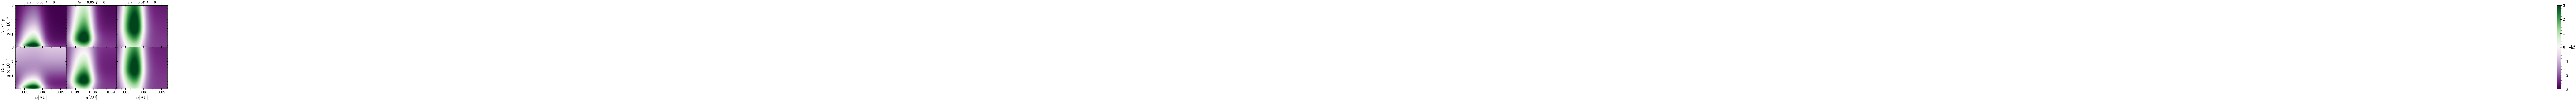

In [7]:
mps = np.linspace(1e-6, 3e-5, 500)
rps = sigma[:,0]
a = []

cmaps = ['PRGn', 'viridis']

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 5), sharex=True, sharey=True)

ax[0, 0].set_xlim(0.015, 0.1)
ax[0, 0].set_ylabel('No Gap \n' + r'$q \times 10^{-5}$')
ax[1, 0].set_ylabel('Gap \n' + r'$q \times 10^{-5}$')

ax[1, 0].set_xticks([0.03 + i * 0.03 for i in range(3)])

alphaf_N = -np.gradient(np.log(sigma[:,1]), np.log(sigma[:,0]))
f = 0

for index, h0 in enumerate([0.03, 0.05, 0.07]):
    visc = Viscosity(rad=rps, alpha_visc=5e-4, h0=h0, flaring=f, transition=False)
    Gamma_No_Gap = np.zeros([500, 500])
    Gamma_Gap = np.zeros([500, 500])
    sma = []
    for i in range(500): # r counter
        for j in range(500): # mass counter
            
            tor_total_s, lin, coro_s = TheoScaledTorque(r=rps[i+4], viscosity=visc[i+4], betaf=-2*f+1.0, \
                                                        alphaf=alphaf_N[i+4], h=h0*rps[i+4]**f, smoothing=0.6, \
                                                        mass=mps[j], unsaturated=False, kanagawa=False, Kt=20)

            Gamma_No_Gap[j, i] = tor_total_s

            tor_total_sG, linG, coro_sG = TheoScaledTorque(r=rps[i+4], viscosity=visc[i+4], betaf=-2*f+1.0, \
                                                        alphaf=alphaf_N[i+4], h=h0*rps[i+4]**f, smoothing=0.6, \
                                                        mass=mps[j], unsaturated=False, kanagawa=True, Kt=20)
            Gamma_Gap[j, i] = tor_total_sG
        sma.append(rps[i+4])
        
    ax[0, index].pcolormesh(sma, mps*1e5, Gamma_No_Gap, cmap=cmaps[0], vmin=-3, vmax=3)
    pcm1 = ax[1, index].pcolormesh(sma, mps*1e5, Gamma_Gap, cmap=cmaps[0], vmin=-3, vmax=3)
    ax[0, index].set_title(fr"$h_{{\mathrm{{0}}}}={h0}\;f={f}$")
    ax[1, index].set_xlabel("$a$[AU]")

cbar = fig.colorbar(pcm1, ax=ax, orientation='vertical', anchor=(130, 1))
cbar.set_label(r"$\frac{\Gamma}{\Gamma_0}$", labelpad=0)

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('C1.png', dpi=150)
plt.show()